## Surrogate model for ZDT2 problem 

Problem setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
from pymoo.problems import get_problem


np.random.seed(0)

# Problem Definition
n_obj = 2  # zdt2 ha 2 obiettivi
n_vars = 30  # Numero di variabili decisionali per zdt2
problem = get_problem("zdt2")

def scalarized_objective(x, lambdas):
    """
    Scalarized objective function for zdt2.
   
    """
    f = problem.evaluate(np.array([x]))[0]  
    result = np.dot(lambdas, f)  
    

    return result

def optimize_for_lambda(lambdas, x_range=(0.0, 1.0)):
    
    lambdas = np.array(lambdas)
    

    if not np.isclose(np.sum(lambdas), 1.0) or np.any(lambdas < 0):
        raise ValueError("lambdas must be non-negative and sum to 1")
    
    def objective(x):
        return scalarized_objective(x, lambdas)
    
    starting_points = np.linspace(x_range[0], x_range[1], 10)
    best_result = None
    lowest_loss = float('inf')
    
    for start in starting_points:
       
        x0 = np.clip(np.full(n_vars, start), x_range[0], x_range[1])
    
        if np.any(x0 < x_range[0]) or np.any(x0 > x_range[1]):
            raise ValueError(f"x0 violates bounds: {x0}")
        
        result = minimize(
            objective,
            x0=x0,
            bounds=[(x_range[0], x_range[1])] * n_vars,
            method='L-BFGS-B'
        )
        
        if result.success and result.fun < lowest_loss:
            lowest_loss = result.fun
            best_result = result
    
    if best_result is None:
        raise ValueError("Optimization failed for the given lambda values.")
    
    return best_result.x, best_result.fun

Plots the optimal loss surface for different lambda combinations (lambda1 and lambda2)

In [3]:
def plot_optimal_values_surface():
    """
    Plot the optimal loss surface for the zdt2 problem with lambda1 and lambda2.
    """
    resolution = 20
    lambda1_vals = np.linspace(0, 1, resolution)
    
    valid_lambda1 = []
    valid_lambda2 = []
    optimal_losses = []
    optimal_x_values = []
    
    for l1 in lambda1_vals:
        l2 = 1 - l1  # lambda2 is determined as 1 - lambda1
        
        lambdas = np.array([l1, l2])
        
        # Log per debug
        print(f"plot_optimal_values_surface: lambdas={lambdas}")
        
        x_min, loss_min = optimize_for_lambda(lambdas)
        
        valid_lambda1.append(l1)
        valid_lambda2.append(l2)
        optimal_losses.append(loss_min)
        optimal_x_values.append(x_min)
    
    valid_lambda1 = np.array(valid_lambda1)
    valid_lambda2 = np.array(valid_lambda2)
    optimal_losses = np.array(optimal_losses)
    optimal_x_values = np.array(optimal_x_values)
    
    # Create the 2D plot
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(valid_lambda1, valid_lambda2, c=optimal_losses, cmap=cm.viridis, s=50, alpha=0.8)
    
    colorbar = fig.colorbar(scatter, ax=ax, shrink=0.8, aspect=10)
    colorbar.set_label('Optimal Loss Value', fontsize=12)
    
    ax.set_xlabel('Lambda 1')
    ax.set_ylabel('Lambda 2')
    ax.set_title('Optimal Loss for Different Lambda Combinations (zdt2)')
    ax.set_aspect('equal')
    
    plt.savefig('optimal_loss_surface_zdt2.png', dpi=300)
    return fig

plot_optimal_values_surface: lambdas=[0. 1.]
plot_optimal_values_surface: lambdas=[0.05263158 0.94736842]
plot_optimal_values_surface: lambdas=[0.10526316 0.89473684]
plot_optimal_values_surface: lambdas=[0.15789474 0.84210526]
plot_optimal_values_surface: lambdas=[0.21052632 0.78947368]
plot_optimal_values_surface: lambdas=[0.26315789 0.73684211]
plot_optimal_values_surface: lambdas=[0.31578947 0.68421053]
plot_optimal_values_surface: lambdas=[0.36842105 0.63157895]
plot_optimal_values_surface: lambdas=[0.42105263 0.57894737]
plot_optimal_values_surface: lambdas=[0.47368421 0.52631579]
plot_optimal_values_surface: lambdas=[0.52631579 0.47368421]
plot_optimal_values_surface: lambdas=[0.57894737 0.42105263]
plot_optimal_values_surface: lambdas=[0.63157895 0.36842105]
plot_optimal_values_surface: lambdas=[0.68421053 0.31578947]
plot_optimal_values_surface: lambdas=[0.73684211 0.26315789]
plot_optimal_values_surface: lambdas=[0.78947368 0.21052632]
plot_optimal_values_surface: lambdas=[0.

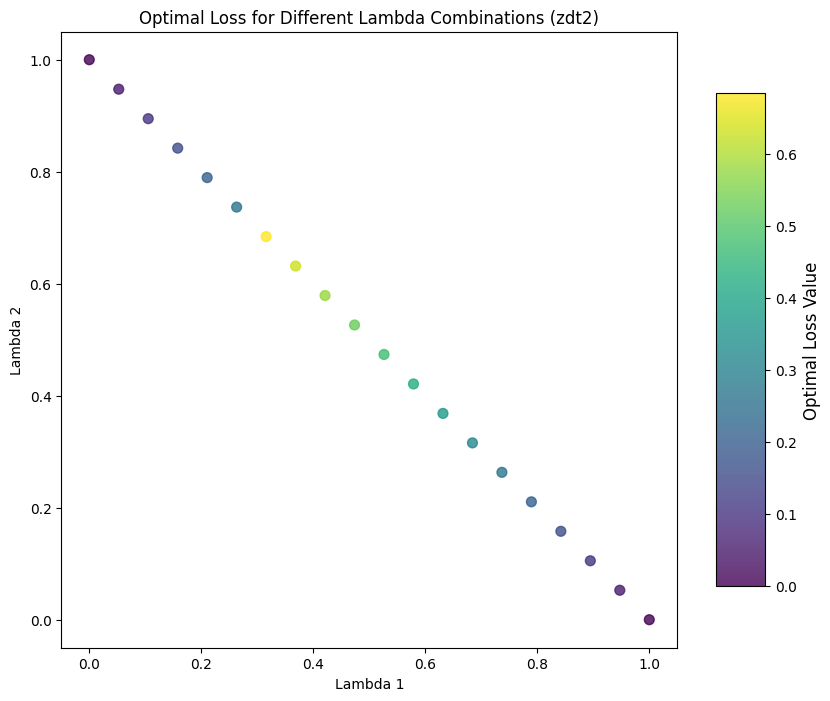

In [4]:
# Execute the code
if __name__ == "__main__":
    
    # Plot the optimal loss 2D surface for zdt2
    plot_optimal_values_surface()
    
    # Sample a few specific lambda combinations and print their optimal values
    lambda_combinations = [
        [0.5, 0.5],  # Equal weights
        [0.8, 0.2],  # Mostly λ1
        [0.2, 0.8],  # Mostly λ2
        [1.0, 0.0],  # Only λ1
        [0.0, 1.0]   # Only λ2
    ]
    
    print("\nOptimal solutions for specific lambda combinations:")
    print("-" * 50)
    print(f"{'Lambda':20s} | {'Optimal Loss':12s}")
    print("-" * 50)
    
    # Calculate and print the optimal solutions for each lambda combination
    for lambdas in lambda_combinations:
        _, loss_min = optimize_for_lambda(lambdas)
        lambda_str = f"[{lambdas[0]:.2f}, {lambdas[1]:.2f}]"
        print(f"{lambda_str:20s} | {loss_min:12.6f}")
        
    plt.show()

Computes a 2x2 covariance matrix to measure the sensitivity of the optimal loss to small changes in lambda values.
Generates random lambda samples from the simplex (lambda1 + lambda2 = 1).

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
from tqdm import tqdm

def calculate_lambda_covariance(lambdas, delta=0.01):
    """
    Calculate the covariance matrix showing how the optimal loss changes
    with small perturbations in lambda values for zdt2.
    
    Parameters:
    lambdas: Base lambda values [λ1, λ2] where sum is 1
    delta: Small perturbation amount for finite difference approximation
    
    Returns:
    2x2 covariance matrix
    """
    # Calculate the optimal loss at the base lambda point
    x_opt, base_loss = optimize_for_lambda(lambdas)
    
    # Store perturbed losses
    perturbed_losses = np.zeros((2, 2))
    
    # For each pair of lambdas, calculate the perturbation effect
    for i in range(2):
        for j in range(2):
            if i == j:
                # Diagonal elements - single parameter perturbation
                lambda_perturbed = lambdas.copy()
                lambda_perturbed[i] += delta
                lambda_perturbed[1 - i] -= delta  # Maintain sum=1
                
                if np.all(lambda_perturbed >= 0):
                    x_pert, pert_loss = optimize_for_lambda(lambda_perturbed)
                    perturbed_losses[i, i] = (pert_loss - base_loss) / delta
                else:
                    perturbed_losses[i, i] = 0
            else:
                # Off-diagonal elements
                lambda_perturbed = lambdas.copy()
                lambda_perturbed[i] += delta / 2
                lambda_perturbed[j] += delta / 2
                lambda_perturbed[1 - i - j] -= delta  # Adjust the other parameter
                
                if np.all(lambda_perturbed >= 0):
                    x_pert, pert_loss = optimize_for_lambda(lambda_perturbed)
                    single_i_change = perturbed_losses[i, i] * delta / 2
                    single_j_change = perturbed_losses[j, j] * delta / 2
                    total_change = pert_loss - base_loss
                    interaction = total_change - single_i_change - single_j_change
                    perturbed_losses[i, j] = interaction / ((delta / 2) * (delta / 2))
                    perturbed_losses[j, i] = perturbed_losses[i, j]  # Symmetric
                else:
                    perturbed_losses[i, j] = 0
                    perturbed_losses[j, i] = 0
    
    return perturbed_losses

def sample_from_simplex(n_samples):
    """
    Generate random samples from the simplex for λ1 and λ2 (λ2 = 1 - λ1).
    """
    lambda1_samples = np.random.uniform(0, 1, n_samples)
    lambda2_samples = 1 - lambda1_samples
    return np.column_stack((lambda1_samples, lambda2_samples))

def generate_lambda_covariance_samples(n_samples=1000):
    """
    Generate lambda samples and calculate covariance matrices for zdt2.
    """
    # Generate lambda samples
    lambda_samples = sample_from_simplex(n_samples)
    
    # Initialize arrays to store results
    results = []
    
    # Calculate optimal values and covariances
    for i in tqdm(range(n_samples), desc="Calculating covariances"):
        lambdas = lambda_samples[i]
        x_opt, loss_opt = optimize_for_lambda(lambdas)
        
        # Calculate covariance matrix
        cov_matrix = calculate_lambda_covariance(lambdas)
        
        # Store results
        results.append({
            'lambda1': lambdas[0],
            'lambda2': lambdas[1],
            'x_optimal': x_opt,
            'loss_optimal': loss_opt,
            'cov_11': cov_matrix[0, 0],
            'cov_12': cov_matrix[0, 1],
            'cov_21': cov_matrix[1, 0],
            'cov_22': cov_matrix[1, 1],
            'sensitivity_norm': np.linalg.norm(cov_matrix)
        })
    return pd.DataFrame(results)

Visualizes the sensitivity of the optimal loss to lambda perturbations.

In [6]:
def visualize_covariance_results(df):
    """
    Create visualizations for the lambda-covariance samples using the zdt2 benchmark problem.
    """
    # 1. Plot the sensitivity norm on the simplex
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    scatter = ax1.scatter(df['lambda1'], df['lambda2'], c=df['sensitivity_norm'], 
                          cmap='viridis', s=30, alpha=0.7)
    plt.colorbar(scatter, label='Sensitivity Norm (Covariance Matrix)')
    
    # Add the simplex boundary (lambda2 = 1 - lambda1)
    ax1.plot([0, 1], [1, 0], 'k-', linewidth=1.5)
    
    # Add labels
    ax1.text(0, 0, 'λ2 = 1', fontsize=12, ha='center', va='center')
    ax1.text(1, 0, 'λ1 = 1', fontsize=12, ha='center', va='center')
    
    ax1.set_xlabel('Lambda 1', fontsize=12)
    ax1.set_ylabel('Lambda 2', fontsize=12)
    ax1.set_title('Sensitivity of Optimal Loss to Lambda Perturbations (zdt2)', fontsize=14)
    ax1.set_aspect('equal')
    
    plt.savefig('sensitivity_norm_simplex_zdt2.png', dpi=300)
    
    # 2. Histogram of sensitivity norms
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ax2.hist(df['sensitivity_norm'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Sensitivity Norm', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Sensitivity Norms (zdt2)', fontsize=14)
    
    plt.savefig('sensitivity_norm_histogram_zdt2.png', dpi=300)
    
    return fig1, fig2


Generating 1000 lambda-covariance samples...
Creating visualizations...

Summary statistics of sensitivity norms:
count     1000.000000
mean       738.652804
std       1646.342886
min          1.000000
25%        565.687193
50%        565.687193
75%        565.687193
max      21452.995941
Name: sensitivity_norm, dtype: float64


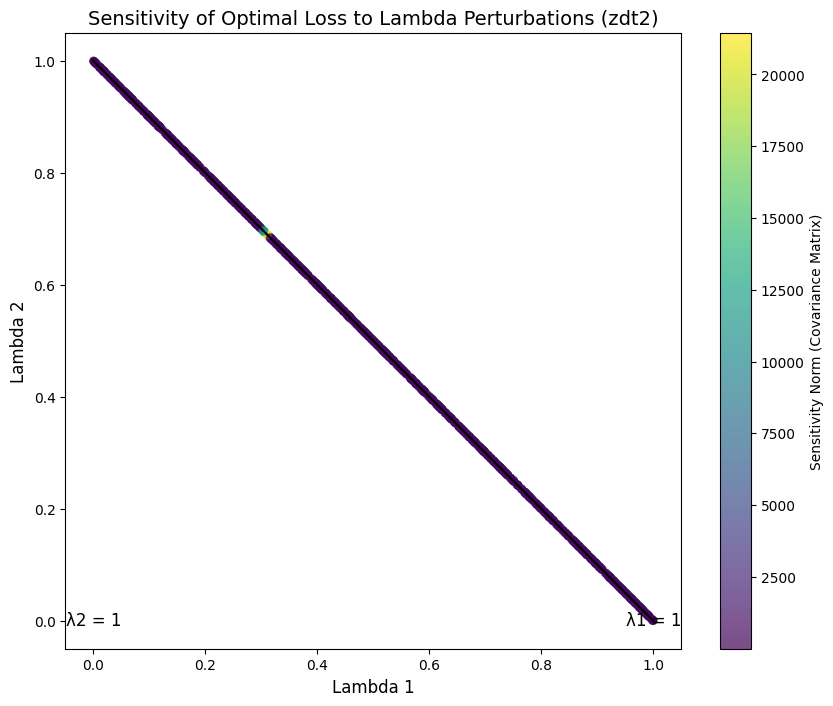

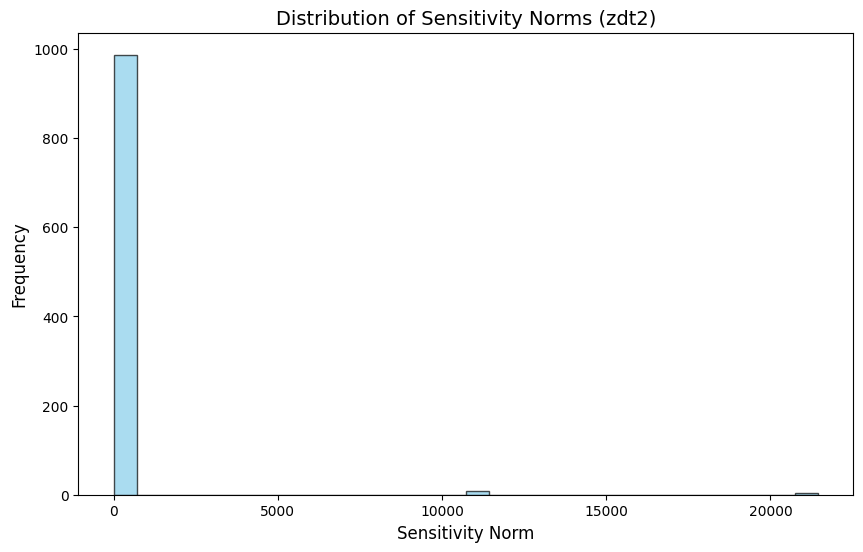

In [12]:
if __name__ == "__main__":
    # Generate samples of lambda and covariance pairs
    print("\nGenerating 1000 lambda-covariance samples...")
    lambda_cov_samples = generate_lambda_covariance_samples(n_samples=1000)
    
    # Save the samples to CSV
    lambda_cov_samples.to_csv(' problemZDT2.csv', index=False)
    
    # Visualize the results
    print("Creating visualizations...")
    visualize_covariance_results(lambda_cov_samples)
    
    # Display summary statistics
    print("\nSummary statistics of sensitivity norms:")
    print(lambda_cov_samples['sensitivity_norm'].describe())
    
    # Show the plots
    plt.show()

Fits a Gaussian Process model to predict the sensitivity norm based on lambda values.
Evaluates the model's performance using metrics like MSE, RMSE, MAE, and R².


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the data generated by the zdt2 benchmark problem
def load_lambda_covariance_data(file_path=' problemZDT2.csv'):
    """Load the lambda-covariance data from CSV file"""
    return pd.read_csv(file_path)

def fit_gp_model(data, n_training=100, random_state=42):
    """
    Fit a Gaussian Process model to predict sensitivity_norm from lambda values
    using the specified kernel configuration.
    
    Parameters:
    data: DataFrame with lambda and sensitivity data
    n_training: Number of samples to use for training
    random_state: Random seed for reproducibility
    
    Returns:
    model: Fitted GP model
    X_train, X_test: Training and test feature sets
    y_train, y_test: Training and test target values
    scaler_X, scaler_y: Data scalers
    """
    # Extract features (lambda1) and target (sensitivity_norm)
    data['lambda2'] = 1 - data['lambda1']  # Calculate lambda2 as 1 - lambda1
    X = data[['lambda1','lambda2']].values  # Only lambda1 is needed
    y = data['sensitivity_norm'].values.reshape(-1, 1)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=n_training, random_state=random_state
    )
    
    # Scale the data
    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)
    
    X_train_scaled = scaler_X.transform(X_train)
    y_train_scaled = scaler_y.transform(y_train)
    
    # Define the kernel
    kernel = ConstantKernel(1.0) * Matern(length_scale=0.1, nu=2.5) + WhiteKernel(noise_level=1e-5)
    
    print("Initial kernel configuration:")
    print(kernel)
    
    # Create and fit the GP model
    model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-10,  # Small alpha for numerical stability
        normalize_y=False,  # We already scaled the data
        n_restarts_optimizer=15,  # More restarts to find better hyperparameters
        random_state=random_state
    )
    
    # Fit the model
    print("\nFitting Gaussian Process model with optimized kernel...")
    model.fit(X_train_scaled, y_train_scaled)
    
    print(f"\nOptimized kernel parameters:")
    print(model.kernel_)
    
    # Print the learned noise level
    if hasattr(model.kernel_, 'k2') and hasattr(model.kernel_.k2, 'noise_level'):
        print(f"\nLearned noise level: {model.kernel_.k2.noise_level:.6f}")
    else:
        for param_name, param in model.kernel_.get_params().items():
            if isinstance(param, WhiteKernel):
                print(f"\nLearned noise level: {param.noise_level:.6f}")
    
    # Log marginal likelihood (higher is better)
    print(f"\nLog marginal likelihood: {model.log_marginal_likelihood(model.kernel_.theta):.4f}")
    
    return model, X_train, X_test, y_train, y_test, scaler_X, scaler_y

def evaluate_model(model, X_test, y_test, scaler_X, scaler_y):
    """
    Evaluate the GP model on test data
    
    Returns:
    y_pred: Predicted values
    metrics: Dictionary of evaluation metrics
    """
    # Scale the test data
    X_test_scaled = scaler_X.transform(X_test)
    
    # Make predictions
    y_pred_scaled, y_std_scaled = model.predict(X_test_scaled, return_std=True)
    
    # Unscale the predictions
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_std = y_std_scaled * scaler_y.scale_
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }
    
    return y_pred, y_std, metrics

Scatter plot to compare the predicted objective values from the Gaussian Process model against the true objective values.
Visualizes the Gaussian Process model's predicted objective surface over the lambda simplex.
Overlays the training and test points on the plots to show how well the model fits the data.

In [15]:
def plot_gp_surface_with_test_points(model, X_train, X_test, y_train, y_test, y_pred, 
                                    y_std, scaler_X, scaler_y):
    """
    Plot the GP model surface and the test points for the zdt2 problem
    """
    # Create a grid for the lambda simplex
    resolution = 50
    l1 = np.linspace(0, 1, resolution)
    l2 = 1 - l1  # lambda2 = 1 - lambda1
    L1, L2 = np.meshgrid(l1, l2)
    
    # Create a mesh grid of lambda values
    X_mesh = np.column_stack((L1.ravel(), L2.ravel()))
    
    # Scale the points and predict
    X_mesh_scaled = scaler_X.transform(X_mesh)
    y_mesh_scaled, y_mesh_std_scaled = model.predict(X_mesh_scaled, return_std=True)
    
    # Unscale the predictions
    y_mesh = scaler_y.inverse_transform(y_mesh_scaled.reshape(-1, 1)).ravel()
    y_mesh_std = y_mesh_std_scaled * scaler_y.scale_
    
    # Set up the 3D figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Reshape for plotting
    L1_valid = X_mesh[:, 0]
    L2_valid = X_mesh[:, 1]
    
    # Plot the GP surface using triangulation
    ax.plot_trisurf(L1_valid, L2_valid, y_mesh, 
                   cmap=cm.viridis, alpha=0.7, linewidth=0.2, edgecolor='gray')
    
    # Plot training points in red
    ax.scatter(X_train[:, 0], X_train[:, 1], y_train, 
              color='red', s=5, label='Training points')
    
    # Plot test points in blue
    ax.scatter(X_test[:, 0], X_test[:, 1], y_test, 
              color='blue', s=8, label='Test points')
    
    # Set labels and title
    ax.set_xlabel('Lambda 1')
    ax.set_ylabel('Lambda 2')
    ax.set_zlabel('Objective Value')
    ax.set_title('GP Model of Objective for zdt2')
    ax.legend()
    
    plt.savefig('gp_objective_surface_zdt2.png', dpi=300, bbox_inches='tight')
    
    # Create a 2D plot of the model prediction on the simplex with uncertainty
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    # Create a triangulation for plotting
    triang_plot = plt.matplotlib.tri.Triangulation(L1_valid, L2_valid)
    
    # Plot the mean prediction
    tcf = ax2.tricontourf(triang_plot, y_mesh, levels=20, cmap='viridis')
    plt.colorbar(tcf, ax=ax2, label='Predicted Objective Value')
    
    # Plot the training and test points
    ax2.scatter(X_train[:, 0], X_train[:, 1], c='red', s=30, alpha=0.7, label='Training')
    ax2.scatter(X_test[:, 0], X_test[:, 1], c='blue', s=30, alpha=0.7, label='Test')
    
    # Add the simplex boundary
    ax2.plot([0, 1, 0], [0, 0, 1], 'k-')
    
    # Labels
    ax2.text(0, 0, 'λ2 = 1', fontsize=12)
    ax2.text(1, 0, 'λ1 = 1', fontsize=12)
    
    ax2.set_xlabel('Lambda 1')
    ax2.set_ylabel('Lambda 2')
    ax2.set_title('GP Model Prediction on Lambda Simplex (zdt2)')
    ax2.set_aspect('equal')
    ax2.legend()
    
    plt.savefig('gp_objective_2d_zdt2.png', dpi=300, bbox_inches='tight')
    
    return fig, fig2

def plot_predicted_vs_true(y_test, y_pred, y_std):
    """
    Create a scatter plot of predicted vs true objective values for zdt2
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the diagonal perfect prediction line
    max_val = max(np.max(y_test), np.max(y_pred))
    min_val = min(np.min(y_test), np.min(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect prediction')
    
    # Plot the predictions with error bars (95% confidence intervals)
    ax.errorbar(y_test.ravel(), y_pred.ravel(), yerr=1.96*y_std, 
                fmt='o', markersize=8, alpha=0.6, 
                ecolor='lightgray', capsize=5)
    
    # Add correlation coefficient
    correlation = np.corrcoef(y_test.ravel(), y_pred.ravel())[0, 1]
    ax.annotate(f'Correlation: {correlation:.4f}', xy=(0.05, 0.95), 
                xycoords='axes fraction', fontsize=12)
    
    # Set labels and title
    ax.set_xlabel('True Objective Value')
    ax.set_ylabel('Predicted Objective Value')
    ax.set_title('Predicted vs. True Objective Value (zdt2)')
    
    # Add a grid for better readability
    ax.grid(True, alpha=0.3)
    
    # Make the plot square
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('predicted_vs_true_zdt2.png', dpi=300)
    
    return fig

Loading lambda-covariance data for ZDT2...
Loaded 1000 samples.
Initial kernel configuration:
1**2 * Matern(length_scale=0.1, nu=2.5) + WhiteKernel(noise_level=1e-05)

Fitting Gaussian Process model with optimized kernel...

Optimized kernel parameters:
0.863**2 * Matern(length_scale=0.0149, nu=2.5) + WhiteKernel(noise_level=0.000412)

Learned noise level: 0.000412

Log marginal likelihood: -85.3597

Model performance on test data:
MSE: 268366.9480
RMSE: 518.0415
MAE: 61.2454
R²: 0.8640

Creating visualizations...

All visualizations have been saved.
Done!


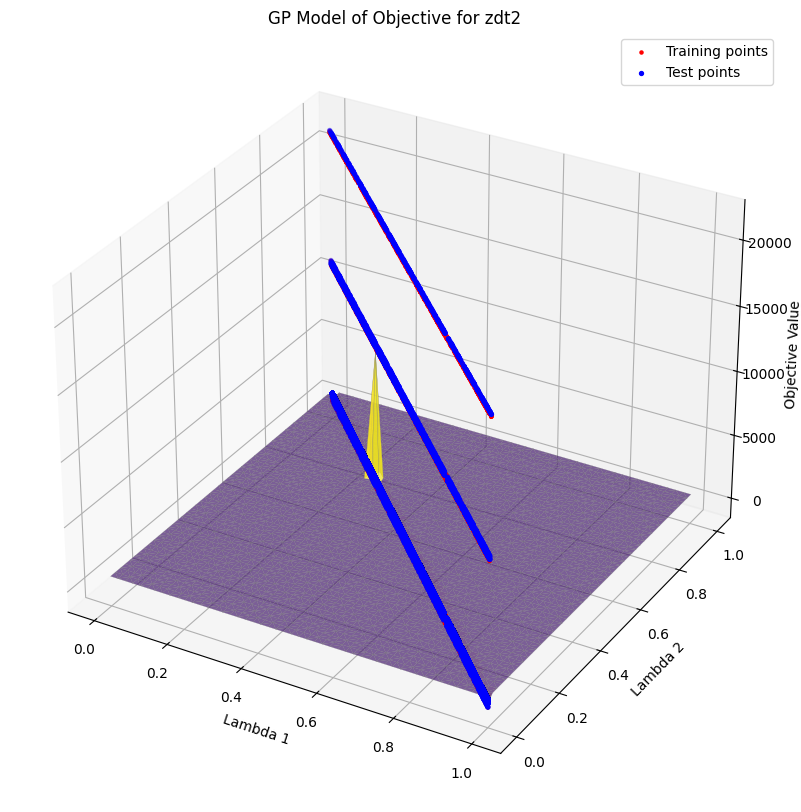

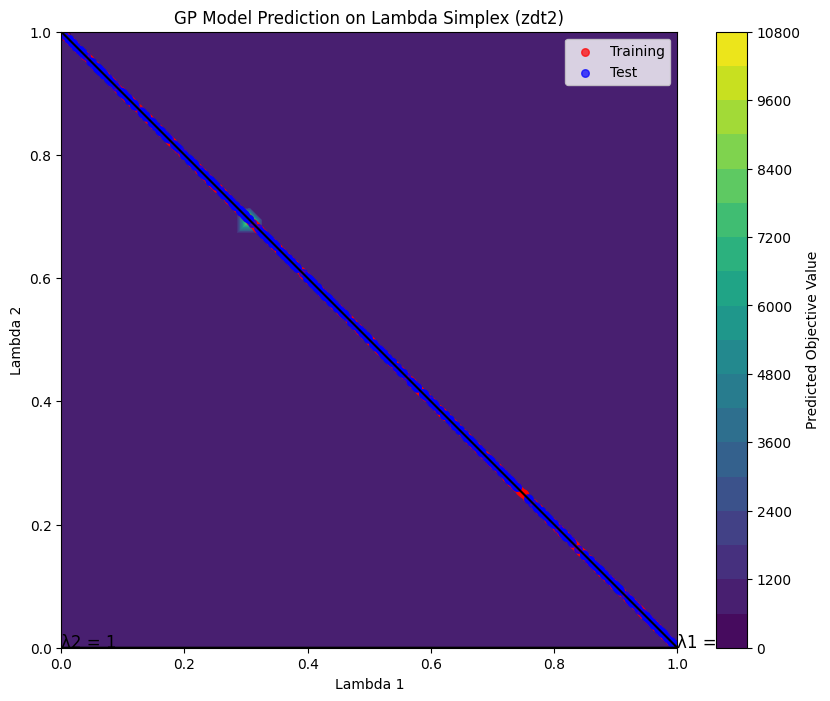

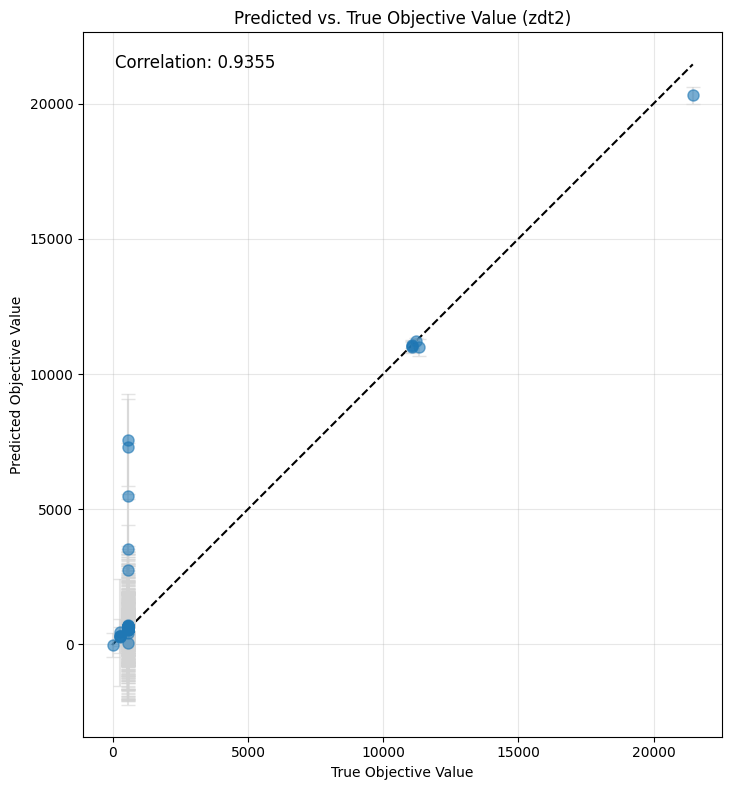

In [16]:
def main():
    """Main function to orchestrate the GP modeling and evaluation for zdt2"""
    # Load the data
    print("Loading lambda-covariance data for ZDT2...")
    data = load_lambda_covariance_data()
    print(f"Loaded {len(data)} samples.")
    
    # Ensure lambda2 is calculated to respect the simplex constraint
    data['lambda2'] = 1 - data['lambda1']
    
    # Fit the GP model
    model, X_train, X_test, y_train, y_test, scaler_X, scaler_y = fit_gp_model(data, n_training=500)
    
    # Evaluate the model
    y_pred, y_std, metrics = evaluate_model(model, X_test, y_test, scaler_X, scaler_y)
    
    # Print metrics
    print("\nModel performance on test data:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Plot the GP surface with test points
    print("\nCreating visualizations...")
    plot_gp_surface_with_test_points(model, X_train, X_test, y_train, y_test, y_pred, 
                                    y_std, scaler_X, scaler_y)
    
    # Plot predicted vs true values
    plot_predicted_vs_true(y_test, y_pred, y_std)
    
    print("\nAll visualizations have been saved.")
    print("Done!")

if __name__ == "__main__":
    main()